# MLP para clasificación

Importar las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

from sklearn.model_selection import GridSearchCV

Leemos los datos

In [2]:
data = pd.read_csv('data_cleaner1.csv')

X = data.drop(columns=['AdoptionLikelihood'])
y = data['AdoptionLikelihood'].astype(int)

Dividimos en train y en test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

## Primera parte

Definimos la función de experimentar para probar los diferentes parámetros para las redes neuronales

In [4]:
def experimentar_mlp_clf(param_grid, X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    resultados = []

    for config in param_grid:
        hidden_layers = config['hidden_layer_sizes']
        activation = config['activation']
        alpha = config['alpha']
        lr = config['learning_rate_init']

        accs, precs, recalls, aucs = [], [], [], []

        for train_idx, val_idx in kf.split(X, y):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            clf = MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation=activation,
                alpha=alpha,
                learning_rate_init=lr,
                max_iter=2000,
                early_stopping=True,
                random_state=42
            )

            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_val)
            y_proba = clf.predict_proba(X_val)[:, 1]

            accs.append(accuracy_score(y_val, y_pred))
            precs.append(precision_score(y_val, y_pred))
            recalls.append(recall_score(y_val, y_pred))
            aucs.append(roc_auc_score(y_val, y_proba))

        resultados.append({
            'capas': hidden_layers,
            'activación': activation,
            'alpha': alpha,
            'lr': lr,
            'Accuracy': np.mean(accs),
            'Precision': np.mean(precs),
            'Recall': np.mean(recalls),
            'ROC AUC': np.mean(aucs)
        })

    return pd.DataFrame(resultados)

In [5]:
param_grid = []
for capas in [(32,), (64,), (64, 32), (64, 32, 16)]:
    for act in ['relu', 'tanh']:
        for alpha in [0.0001, 0.001]:
            for lr in [0.001, 0.01]:
                param_grid.append({
                    'hidden_layer_sizes': capas,
                    'activation': act,
                    'alpha': alpha,
                    'learning_rate_init': lr
                })

In [6]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

resultados = experimentar_mlp_clf(param_grid, X_train_np, y_train_np)
resultados_ordenados = resultados.sort_values(by='ROC AUC', ascending=False)

print("Mejores configuraciones:")
print(resultados_ordenados.head(5))

Mejores configuraciones:
           capas activación   alpha    lr  Accuracy  Precision    Recall  \
31  (64, 32, 16)       tanh  0.0010  0.01  0.921495   0.913877  0.840629   
29  (64, 32, 16)       tanh  0.0001  0.01  0.921495   0.913877  0.840629   
23      (64, 32)       tanh  0.0010  0.01  0.914642   0.898454  0.834933   
21      (64, 32)       tanh  0.0001  0.01  0.914642   0.898454  0.834933   
3          (32,)       relu  0.0010  0.01  0.917134   0.901794  0.840539   

     ROC AUC  
31  0.931327  
29  0.931291  
23  0.930186  
21  0.930168  
3   0.926955  


In [7]:
mejor = resultados_ordenados.iloc[0]

clf_final = MLPClassifier(
    hidden_layer_sizes=mejor['capas'],
    activation=mejor['activación'],
    alpha=mejor['alpha'],
    learning_rate_init=mejor['lr'],
    max_iter=2000,
    early_stopping=True,
    random_state=42
)

clf_final.fit(X_train, y_train)

y_pred = clf_final.predict(X_test)
y_proba = clf_final.predict_proba(X_test)[:, 1]

print("\n=== Métricas en el conjunto de prueba ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precisión: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Accuracy:  0.910
Precisión: 0.907
Recall:    0.811
ROC AUC:   0.904


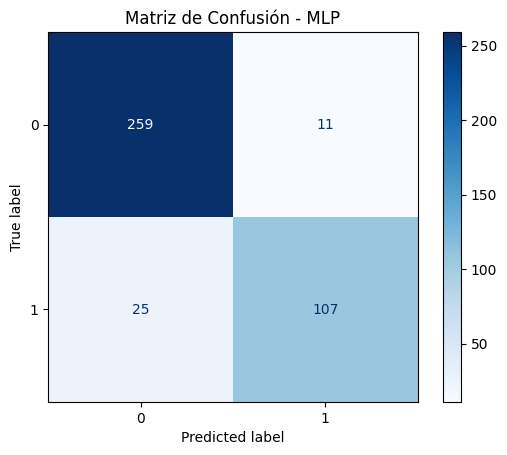

In [8]:
ConfusionMatrixDisplay.from_estimator(clf_final, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusión - MLP")
plt.show()

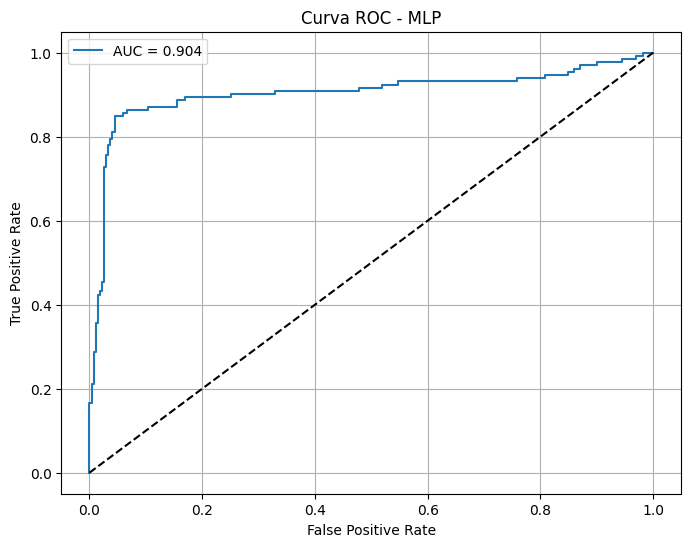

In [9]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MLP')
plt.legend()
plt.grid()
plt.show()


## Segunda parte

Definimos el modelo base

In [10]:
mlp_cv = MLPClassifier(max_iter=2000, early_stopping=True, random_state=42)

Definimos el cross validador

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Definimos la malla de hiperparámetros

In [12]:
param_grid_cv = {
    'hidden_layer_sizes': [(32,), (64,), (64, 32), (64, 32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

Definimos las métricas que calculará el objeto gridsearchcv

In [13]:
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}


Definimos el objeto de grid search

In [14]:
grid_search = GridSearchCV(
    estimator=mlp_cv,
    param_grid=param_grid_cv,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

Hacemos la búsqueda de los mejores hiperparámetros

In [15]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(early_stopping=True, max_iter=2000,
                                     random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(32,), (64,), (64, 32),
                                                (64, 32, 16)],
                         'learning_rate_init': [0.001, 0.01]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall', 'roc_auc': 'roc_auc'},
             verbose=1)

In [16]:
print("\nMejor combinación de hiperparámetros encontrada:")
print(grid_search.best_params_)


Mejor combinación de hiperparámetros encontrada:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01}


In [17]:
print(f"\nMejor ROC AUC promedio en validación: {grid_search.best_score_:.3f}")


Mejor ROC AUC promedio en validación: 0.931


Análisis de métricas promedio en cross validation

In [18]:
resultados_detallados = pd.DataFrame(grid_search.cv_results_)

In [19]:
metricas_promedio = {
    'ROC AUC': {
        'Train': resultados_detallados['mean_train_roc_auc'].mean(),
        'Train_std': resultados_detallados['std_train_roc_auc'].mean(),
        'Validation': resultados_detallados['mean_test_roc_auc'].mean(),
        'Validation_std': resultados_detallados['std_test_roc_auc'].mean()
    },
    'Precision': {
        'Train': resultados_detallados['mean_train_precision'].mean(),
        'Train_std': resultados_detallados['std_train_precision'].mean(),
        'Validation': resultados_detallados['mean_test_precision'].mean(),
        'Validation_std': resultados_detallados['std_test_precision'].mean()
    },
    'Recall': {
        'Train': resultados_detallados['mean_train_recall'].mean(),
        'Train_std': resultados_detallados['std_train_recall'].mean(),
        'Validation': resultados_detallados['mean_test_recall'].mean(),
        'Validation_std': resultados_detallados['std_test_recall'].mean()
    }
}

In [20]:
print("=== PROMEDIOS DE MÉTRICAS EN CROSS-VALIDATION ===\n")
print("Métrica\t\t\tTrain (Mean ± Std)\t\tValidation (Mean ± Std)")
print("-" * 75)

for metrica, valores in metricas_promedio.items():
    train_mean = valores['Train']
    train_std = valores['Train_std']
    val_mean = valores['Validation']
    val_std = valores['Validation_std']

    print(f"{metrica:<15}\t{train_mean:.3f} ± {train_std:.3f}\t\t{val_mean:.3f} ± {val_std:.3f}")

df_metricas = pd.DataFrame({
    'Métrica': list(metricas_promedio.keys()),
    'Train_Mean': [v['Train'] for v in metricas_promedio.values()],
    'Train_Std': [v['Train_std'] for v in metricas_promedio.values()],
    'Validation_Mean': [v['Validation'] for v in metricas_promedio.values()],
    'Validation_Std': [v['Validation_std'] for v in metricas_promedio.values()],
    'Train_Complete': [f"{v['Train']:.3f} ± {v['Train_std']:.3f}" for v in metricas_promedio.values()],
    'Validation_Complete': [f"{v['Validation']:.3f} ± {v['Validation_std']:.3f}" for v in metricas_promedio.values()]
})

print("\n=== TABLA DETALLADA CON DESVIACIONES ESTÁNDAR ===")
display(df_metricas[['Métrica', 'Train_Complete', 'Validation_Complete']].round(4))

=== PROMEDIOS DE MÉTRICAS EN CROSS-VALIDATION ===

Métrica			Train (Mean ± Std)		Validation (Mean ± Std)
---------------------------------------------------------------------------
ROC AUC        	0.883 ± 0.035		0.854 ± 0.037
Precision      	0.854 ± 0.040		0.815 ± 0.049
Recall         	0.679 ± 0.085		0.633 ± 0.091

=== TABLA DETALLADA CON DESVIACIONES ESTÁNDAR ===


,Métrica,Train_Complete,Validation_Complete
0,ROC AUC,0.883 ± 0.035,0.854 ± 0.037
1,Precision,0.854 ± 0.040,0.815 ± 0.049
2,Recall,0.679 ± 0.085,0.633 ± 0.091


In [21]:
mejor_modelo = grid_search.best_estimator_
y_pred_cv = mejor_modelo.predict(X_test)
y_proba_cv = mejor_modelo.predict_proba(X_test)[:, 1]

In [22]:
print("\n=== Métricas en el conjunto de prueba (mejor modelo GridSearchCV) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_cv):.3f}")
print(f"Precisión: {precision_score(y_test, y_pred_cv):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_cv):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_cv):.3f}")


=== Métricas en el conjunto de prueba (mejor modelo GridSearchCV) ===
Accuracy:  0.910
Precisión: 0.907
Recall:    0.811
ROC AUC:   0.904


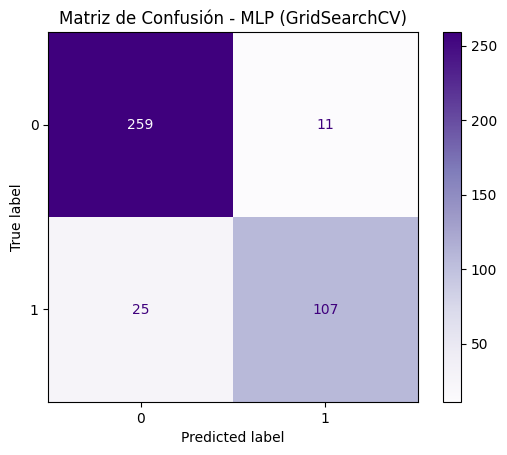

In [23]:
ConfusionMatrixDisplay.from_estimator(mejor_modelo, X_test, y_test, cmap='Purples')
plt.title("Matriz de Confusión - MLP (GridSearchCV)")
plt.show()

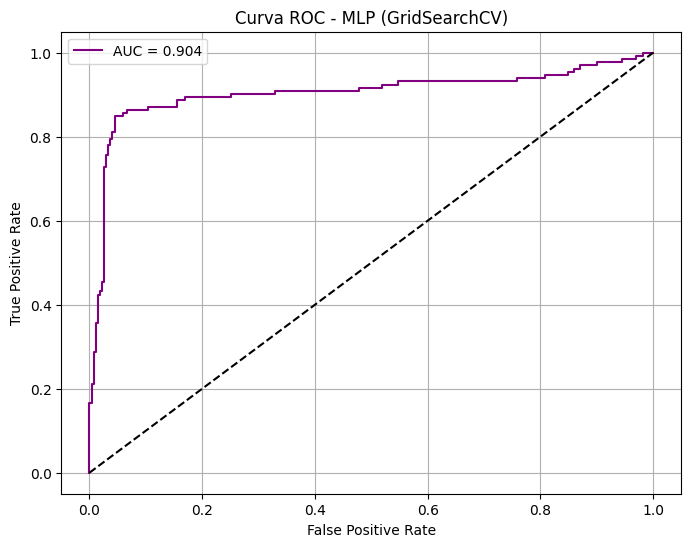

In [24]:
fpr_cv, tpr_cv, _ = roc_curve(y_test, y_proba_cv)
auc_cv = roc_auc_score(y_test, y_proba_cv)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, label=f'AUC = {auc_cv:.3f}', color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MLP (GridSearchCV)')
plt.legend()
plt.grid()
plt.show()

## Visualización del efecto de los hiperparámetros en el ROC AUC

In [25]:
resultados_cv = pd.DataFrame(grid_search.cv_results_)

In [26]:
resultados_cv = resultados_cv.rename(columns={'mean_test_score': 'ROC AUC'})
resultados_cv['capas_str'] = resultados_cv['param_hidden_layer_sizes'].apply(lambda x: str(x))

Influencia de las capas ocultas

In [27]:
print(resultados_cv.columns.tolist())

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_activation', 'param_alpha', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'params', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'split0_train_roc_auc', 'split1_train_roc_auc', 'split2_train_roc_auc', 'split3_train_roc_auc', 'split4_train_roc_auc', 'mean_train_roc_auc', 'std_train_roc_auc', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accuracy', 'split4_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_te

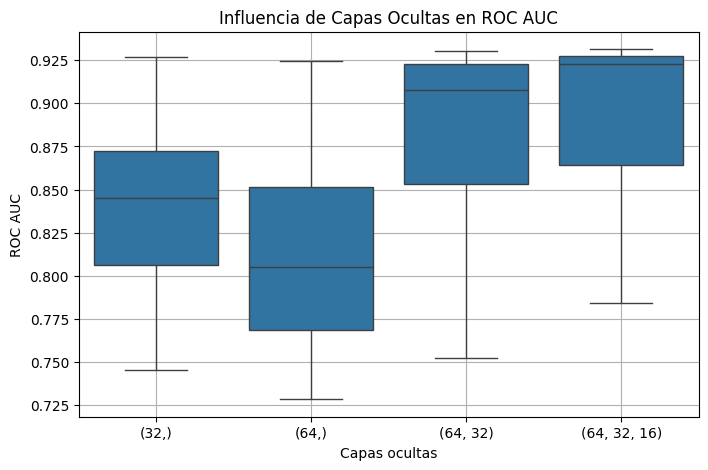

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_cv, x='capas_str', y='mean_test_roc_auc')  # Usar el nombre original
plt.title('Influencia de Capas Ocultas en ROC AUC')
plt.xlabel('Capas ocultas')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

Influencia de la función de activación

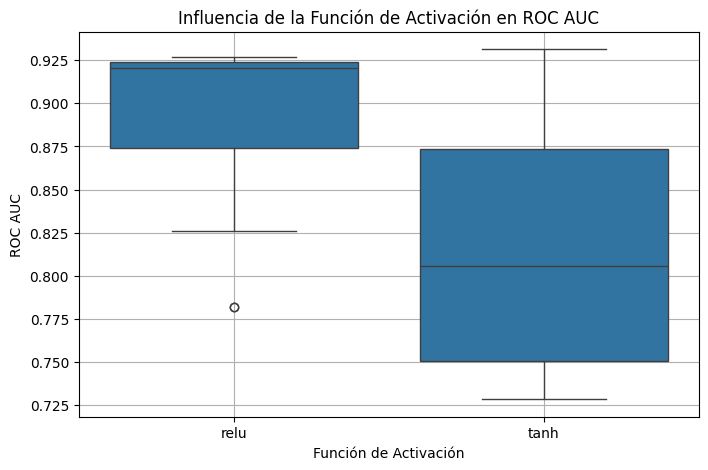

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_cv, x='param_activation', y='mean_test_roc_auc')
plt.title('Influencia de la Función de Activación en ROC AUC')
plt.xlabel('Función de Activación')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

Influencia del alpha

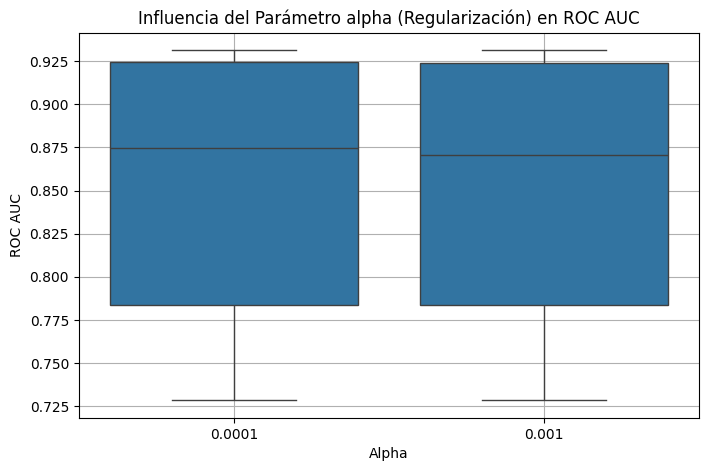

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_cv, x='param_alpha', y='mean_test_roc_auc')
plt.title('Influencia del Parámetro alpha (Regularización) en ROC AUC')
plt.xlabel('Alpha')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

Influencia del learning rate init

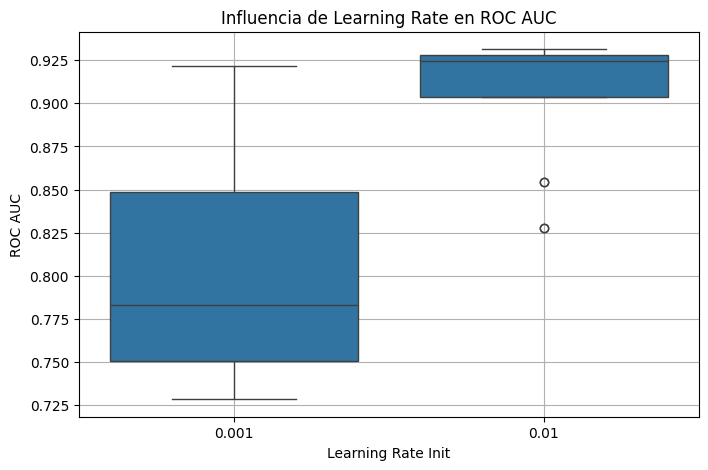

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_cv, x='param_learning_rate_init', y='mean_test_roc_auc')
plt.title('Influencia de Learning Rate en ROC AUC')
plt.xlabel('Learning Rate Init')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

In [32]:
print("\nTop 10 combinaciones por ROC AUC:")
cols = ['param_hidden_layer_sizes', 'param_activation', 'param_alpha', 'param_learning_rate_init', 'mean_test_roc_auc']
display(resultados_cv[cols].sort_values(by='mean_test_roc_auc', ascending=False).head(10))


Top 10 combinaciones por ROC AUC:


,param_hidden_layer_sizes,param_activation,param_alpha,param_learning_rate_init,mean_test_roc_auc
31,"(64, 32, 16)",tanh,0.0010,0.01,0.931327
23,"(64, 32, 16)",tanh,0.0001,0.01,0.931291
29,"(64, 32)",tanh,0.0010,0.01,0.930186
21,"(64, 32)",tanh,0.0001,0.01,0.930168
9,"(32,)",relu,0.0010,0.01,0.926955
1,"(32,)",relu,0.0001,0.01,0.926604
7,"(64, 32, 16)",relu,0.0001,0.01,0.926263
11,"(64,)",relu,0.0010,0.01,0.924685
3,"(64,)",relu,0.0001,0.01,0.923797
15,"(64, 32, 16)",relu,0.0010,0.01,0.923785
